## Прогноз оттока клиентов банка
### Постановка задачи
- Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Имеются  исторические данные о поведении клиентов и расторжении договоров с банком.

#### Описание данных. Признаки
В нашем распоряжении находится таблица, содержащая информацию о клиентах со следующими признаками:
- "RowNumber" — индекс строки в данных
- "CustomerId" — уникальный идентификатор клиента
- "Surname" — фамилия
- "CreditScore" — кредитный рейтинг
- "Geography" — страна проживания
- "Gender" — пол
- "Age" — возраст
- "Tenure" — количество недвижимости у клиента
- "Balance" — баланс на счёте
- "NumOfProducts" — количество продуктов банка, используемых клиентом
- "HasCrCard" — наличие кредитной карты
- "IsActiveMember" — активность клиента
- "EstimatedSalary" — предполагаемая зарплата
- #### Целевой признак

- "Exited"— факт ухода клиента

### План:
1. Изучить общую информацию о структуре данных и признаках

2. Произвести предобработку и подготовить данные к анализу

### 1. Изучить общую информацию о структуре данных и признаках

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import warnings; warnings.filterwarnings(action='once')
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
clients_df = pd.read_csv('Churn.csv')


In [4]:
clients_df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [5]:
clients_df.info()
print ('Количество дубликатов:', clients_df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
Количество дубликатов: 0


#### Вывод
- Перед нами датафрейм в виде таблицы с данными о клиентах банка, состоящей из 10000 строк и 14 столбцов.
- Пропуски имеются лишь в одном столбце - "Tenure" (количество недвижимости у клиента) - однако они количество пропусков не критично (около 1 %), скорее всего данные пропуски означают отсутствие недвижимости у клиента.
- Предварительных критичных замечения к датафрейму нет. В целом данные выгруженны корректно, типы данных отражены корректно, количество пропусков не критично (могут быть заменены на ноль), дубликаты также отсутствуют.
- Замечание: столбец "rownumber" не нужен, поскольку дублирует номер строки (индекса), в связи с чем его можно удалить. Также для целей обучения модели машина вряд ли сочтет полезными фамилии клиентов банка - столбец с фамилиями тоже удалим.

<font color='purple'>

- Учтено замечание об ошибке в количестве пропусков. Как в дальнейшем будет показано, этот признак является существенным в построении предсказания. Однако, в качестве стратегии оставил замену пропусков на нули (скорее всего это кредит длительностью меньше года, нет возможности уточнить).<br>

### 2. Предобработка данных

In [6]:
#приведем к нижнему регистру наименования столбцов
clients_df.columns = map(str.lower, clients_df.columns)
#заменим пропущенные значения в столбце "tenure" на ноль
clients_df = clients_df.fillna(0)
#удалим столбец "rownumber"
clients_df = clients_df.drop('rownumber', axis=1)
clients_df = clients_df.drop('surname', axis=1)
clients_df = clients_df.drop('customerid', axis=1)

In [7]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


### 3. Исследовательский анализ данных

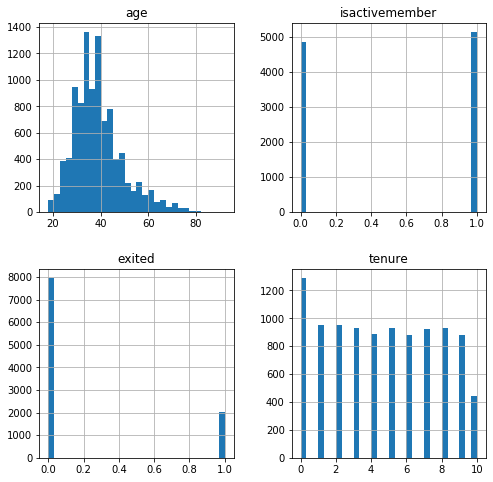

In [8]:
#построим гистограммы для отдельных признаков - категориальных переменных
hist_list_1 = clients_df[['age', 'isactivemember', 'exited', 'tenure']]
hist_list_1.hist(bins=30, figsize=(8, 8));

#### Вывод
<font color='purple'>
Из гистограмм видно следующее:
    
- 'age': большую часть клиентов составляют лица в возрасте от 30 до 45 лет. Выбросов как таковых в этом признаке не наблюдается, хотя небольшой хвост уходит в сторону пожилых клиентов.
- 'isactivemember': активных и неактивных клиентов примерно поровну. Вряд ли этот признак будет сильно значимым для модели.
- 'tenure': самой многочисленной оказалась группа клиентов с tenure равным нулю. Меньше всех клиентов с tenure: 10
- 'exited': доля ушедших клиентов составляет примерно 1/5 часть от общего числа.
    
    <br>

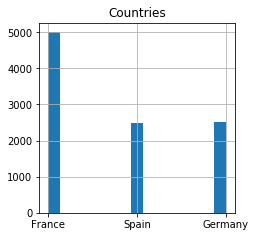

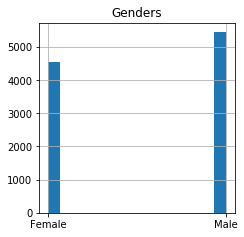

In [9]:
clients_df['geography'].hist(bins=15, figsize=(3.5, 3.5));
plt.title('Countries');
plt.show()
clients_df['gender'].hist(bins=15, figsize=(3.5, 3.5));
plt.title('Genders');


#### Вывод:

<font color='purple'>

- 'countries': больше всего клиентов из Франции (почти в два раза), чем из Испании и Германии.
- 'genders': половое соотношение примерно равно, с небольшим преобладанием мужчин. <br>

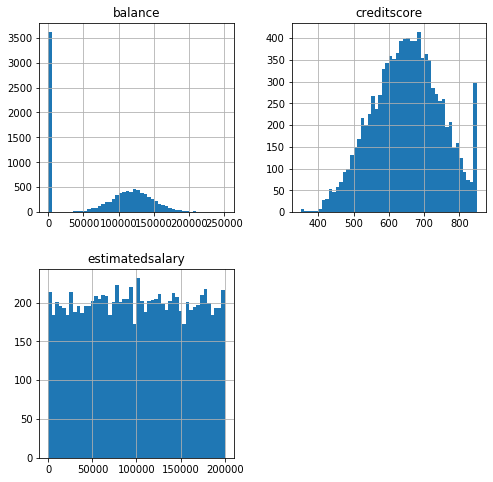

In [10]:
#построим гистограммы для количественных переменных
hist_list_2 = ['balance', 'creditscore', 'estimatedsalary']
#clients_df[hist_list_2]
clients_df[hist_list_2].hist(bins=50, figsize=(8, 8));


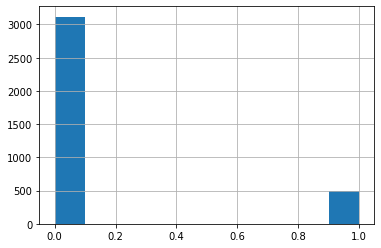

In [11]:
#выведем распределение ушедших и оставшихся клиентов с нулевым балансос 
null_clients = clients_df[clients_df['balance'] == 0]
null_clients['exited'].hist();

#### Вывод:

- 'balance': данная величина в целом распределена нормально, однако есть выбросы - баланс с нулевым значением (чуть больше чем у 3 500 клиентов). Дальше разберем вопрос с выбросами.
- 'creditscore': кредитный рейтинг имеет нормальное распределение.
- 'estimatedsalary': не имеет выбросов или нормального распределения.
- Как мы видим, выбросы в виде нулевого баланса являются вполне рабочим фактором, так как наличие нулевого баланса далеко не говорит о том, что клиент покинет банк.
    

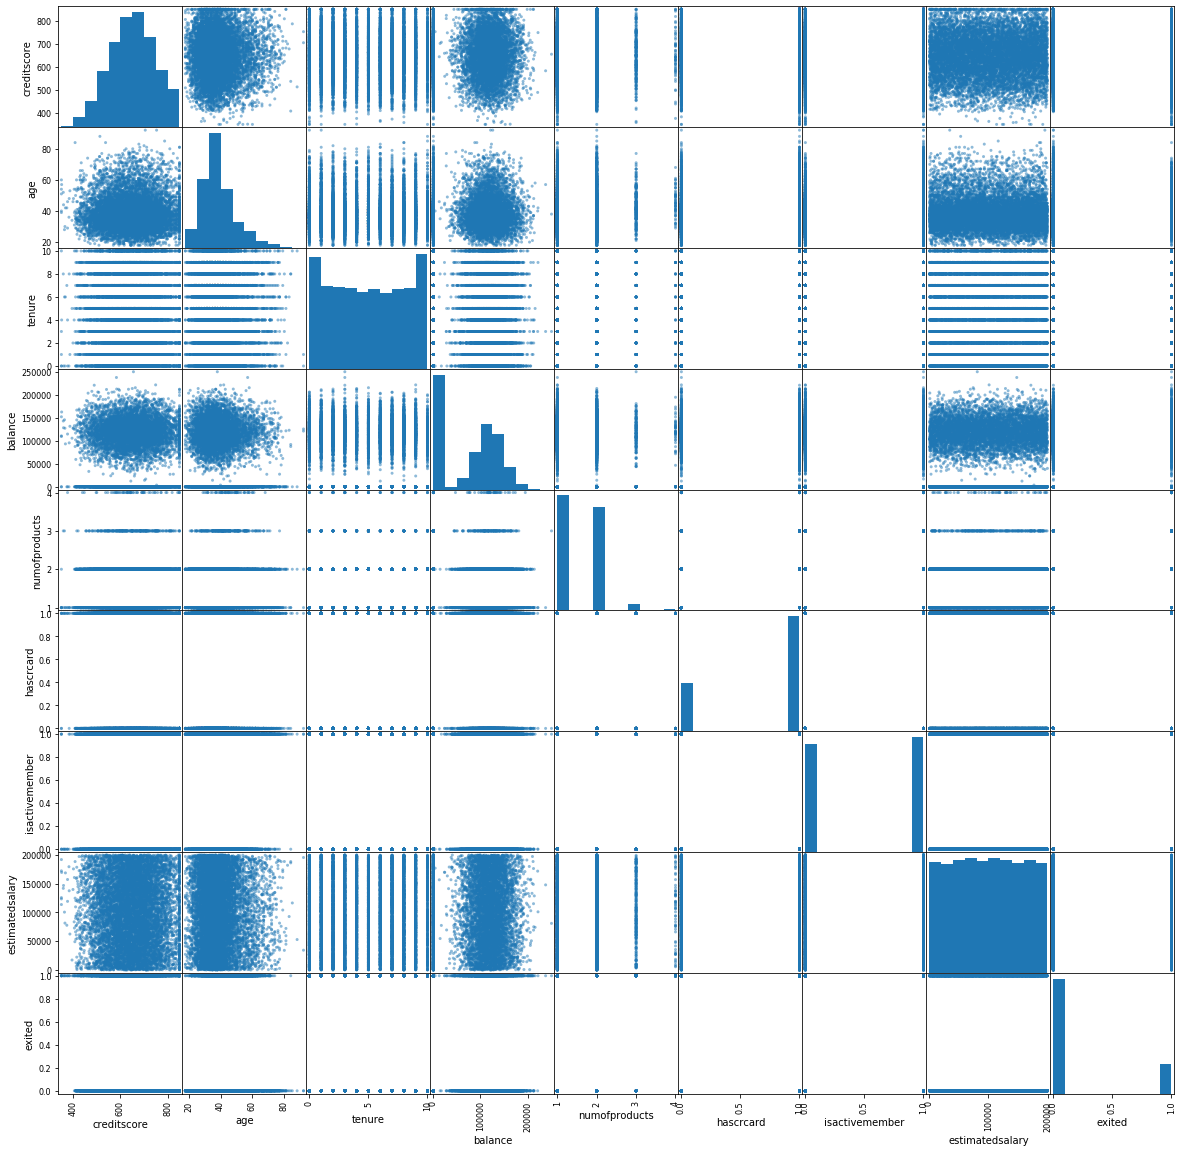

In [12]:
#построим и визуализируем матрицу корреляции
pd.plotting.scatter_matrix(clients_df, figsize=(20, 20));

In [13]:
print(clients_df.corr())

                 creditscore       age    tenure   balance  numofproducts  \
creditscore         1.000000 -0.003965  0.003087  0.006268       0.012238   
age                -0.003965  1.000000 -0.007368  0.028308      -0.030680   
tenure              0.003087 -0.007368  1.000000 -0.005821       0.010106   
balance             0.006268  0.028308 -0.005821  1.000000      -0.304180   
numofproducts       0.012238 -0.030680  0.010106 -0.304180       1.000000   
hascrcard          -0.005458 -0.011721  0.021387 -0.014858       0.003183   
isactivemember      0.025651  0.085472 -0.025856 -0.010084       0.009612   
estimatedsalary    -0.001384 -0.007201  0.011225  0.012797       0.014204   
exited             -0.027094  0.285323 -0.013319  0.118533      -0.047820   

                 hascrcard  isactivemember  estimatedsalary    exited  
creditscore      -0.005458        0.025651        -0.001384 -0.027094  
age              -0.011721        0.085472        -0.007201  0.285323  
tenure       

### Вывод
- Был проведен предварительный исследовательский анализ датасета.
- Основные численные величины распределены нормально, есть выбросы с нулевым балансом счетов клиентов, однако было принято решение их оставить, так как сами по себе они являются значимым фактором в построении модели - наличие нулевого баланса не означает того, что банк скоро потеряет клиента.

### 4. Обучение модели

#### 4.1 Исследование баланса классов. Обучение без ребалансировки

0    0.7963
1    0.2037
Name: exited, dtype: float64


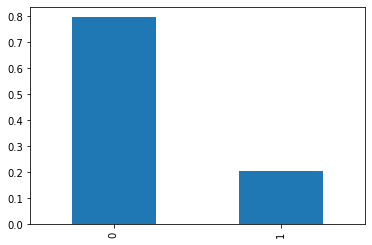

In [14]:
#выведем частотность классов в исходной выборке
class_frequency = clients_df['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

In [15]:
#произведем прямое кодирование признаков в исходной выборке
data_ohe = pd.get_dummies(clients_df, drop_first=True)

#разобьем исходный датасет на обучающую выборку и тестовую. Тестовую отложим для финального тестирования 
data_main, data_test = train_test_split(data_ohe, test_size=0.40, random_state=12345)

#разделим признаки обучающей выборки на целевые и обучающие
features = data_main.drop('exited', axis=1)
target = data_main['exited']

#разделим признаки тестовой выборки на целевые и обучающие
features_test = data_test.drop('exited', axis=1)
target_test = data_test['exited']

#разобьем исходную обучающую выборку на: features_train, features_valid, target_train, target_valid
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              test_size=0.25, random_state=12345)
data_ohe

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


In [16]:
#обучим модель логистической регрессии и выведем метрику accuracy score
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('accuracy score:', accuracy_score(target_valid, predicted_valid))
print("F1:", f1_score(target_valid, predicted_valid))
#проверим модель на адекватность посредством константной модели на валидационной выборке
target_pred_constant = pd.Series(0, index=target_valid.index)
print('accuracy score константной модели:', accuracy_score(target_valid, target_pred_constant))

accuracy score: 0.7933333333333333
F1: 0.14364640883977903
accuracy score константной модели: 0.8013333333333333


#### Выводы
- В первоначальном датасете был обнаружен дисбаланс классов в признаках ответов (соотношение отрицательного класса к положительному около 1:4).
- Метрика accuracy обученной модели логистической регрессии (вместе с константной моделью) выдала формально высокий показатель, однако метрика F1 оказалась на нуле.
- Данные результаты свидетельствуют о том, что необходимо проводить взвешивание и ребалансировку классов, а также масштабирование признаков с целью улучшения качества модели.

#### 4.2 Подготовка признаков

In [17]:
#произведем масштабирование численных признаков
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])




C:\Users\K\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\K\anaconda\anaconda3\lib\site-packages\pandas\core\indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\K\anaconda\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

0    0.500695
1    0.499305
Name: exited, dtype: float64


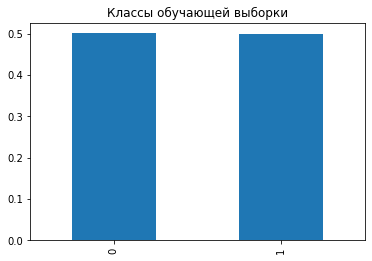

1    0.515714
0    0.484286
Name: exited, dtype: float64


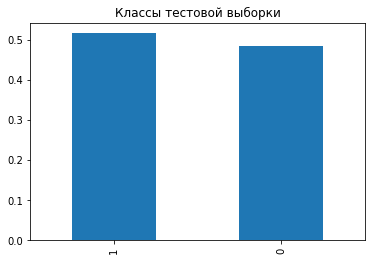

In [18]:
#произведем балансировку классов посредством upsampling обучающей выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
features_upsampled, target_upsampled = upsample(features_train, target_train, 4 )

#произведем балансировку классов посредством upsampling тестовой выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
features_test_upsampled, target_test_upsampled = upsample(features_test, target_test, 4 )

#выведем баланс классов обучающей выборки после ребалансировки
class_frequency = target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');
plt.title('Классы обучающей выборки');
plt.show()
#выведем баланс классов тестовой выборки после ребалансировки
class_test_frequency = target_test_upsampled.value_counts(normalize=True)
print(class_test_frequency)
class_test_frequency.plot(kind='bar');
plt.title('Классы тестовой выборки');

#### Выводы
- Для улучшения обучения были произведены масштабирование численных признаков и upsampling класса положительных ответов до равных долей классов в выборке ответов.

#### 4.2. Модель логистической регрессии

In [19]:
#обучим модель логистической регрессии и выведем метрику accuracy score
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print('Recall:', recall_score(target_valid, predicted_valid))
print('Precision:', precision_score(target_valid, predicted_valid))

F1: 0.47127784290738567
Матрица ошибок
[[848 354]
 [ 97 201]]
Recall: 0.674496644295302
Precision: 0.3621621621621622


#### Вывод
- Модель логистической регрессии сработала слабо. Метрика f1 нулевая.

#### 4.3 Модель "Случайный лес"

In [20]:
#подберем модель randomforestclassifier: надем лучшую max_depth
for depth in range(1, 20):
    model_forest = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=26, criterion='gini', class_weight='balanced')
    model_forest.fit(features_upsampled, target_upsampled)
    predictions_valid = model_forest.predict(features_valid)
    print("depth =", depth, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

print("F1:", f1_score(target_valid, predictions_valid))
print('Матрица ошибок')
print(confusion_matrix(target_valid, predictions_valid))

depth = 1 : 0.7366666666666667
depth = 2 : 0.7406666666666667
depth = 3 : 0.742
depth = 4 : 0.76
depth = 5 : 0.7886666666666666
depth = 6 : 0.7913333333333333
depth = 7 : 0.796
depth = 8 : 0.81
depth = 9 : 0.7986666666666666
depth = 10 : 0.822
depth = 11 : 0.8273333333333334
depth = 12 : 0.826
depth = 13 : 0.8266666666666667
depth = 14 : 0.836
depth = 15 : 0.84
depth = 16 : 0.8433333333333334
depth = 17 : 0.8386666666666667
depth = 18 : 0.8486666666666667
depth = 19 : 0.8466666666666667
F1: 0.574074074074074
Матрица ошибок
[[1115   87]
 [ 143  155]]


In [21]:
#подберем модель randomforestclassifier: найдем лучший estimator
for estim in range(1, 151, 5):
    model_forest = RandomForestClassifier(random_state=12345, max_depth=19, n_estimators=estim, criterion='entropy')
    model_forest.fit(features_upsampled, target_upsampled)
    predictions_valid = model_forest.predict(features_valid)
    print("n_estimators =", estim, ": ", end='')
    print(accuracy_score(target_valid, predictions_valid))

print("F1:", f1_score(target_valid, predictions_valid))
print('Матрица ошибок')
print(confusion_matrix(target_valid, predictions_valid))

n_estimators = 1 : 0.774
n_estimators = 6 : 0.8393333333333334
n_estimators = 11 : 0.8246666666666667
n_estimators = 16 : 0.838
n_estimators = 21 : 0.8373333333333334
n_estimators = 26 : 0.8393333333333334
n_estimators = 31 : 0.8453333333333334
n_estimators = 36 : 0.8466666666666667
n_estimators = 41 : 0.8446666666666667
n_estimators = 46 : 0.844
n_estimators = 51 : 0.8426666666666667
n_estimators = 56 : 0.8446666666666667
n_estimators = 61 : 0.8433333333333334
n_estimators = 66 : 0.8453333333333334
n_estimators = 71 : 0.8453333333333334
n_estimators = 76 : 0.842
n_estimators = 81 : 0.844
n_estimators = 86 : 0.8466666666666667
n_estimators = 91 : 0.844
n_estimators = 96 : 0.8446666666666667
n_estimators = 101 : 0.8446666666666667
n_estimators = 106 : 0.8453333333333334
n_estimators = 111 : 0.8453333333333334
n_estimators = 116 : 0.848
n_estimators = 121 : 0.8473333333333334
n_estimators = 126 : 0.8473333333333334
n_estimators = 131 : 0.8493333333333334
n_estimators = 136 : 0.8493333333

In [22]:
model_forest = RandomForestClassifier(random_state=12345, max_depth=19, n_estimators=146, criterion='entropy')
model_forest.fit(features_upsampled, target_upsampled)
predictions_valid = model_forest.predict(features_valid)
print('Accuracy:', accuracy_score(target_valid, predictions_valid))
print("F1:", f1_score(target_valid, predictions_valid))
print('Матрица ошибок')
print(confusion_matrix(target_valid, predictions_valid))
print('Recall:', recall_score(target_valid, predictions_valid))
print('Precision:', precision_score(target_valid, predictions_valid))

Accuracy: 0.8513333333333334
F1: 0.5831775700934579
Матрица ошибок
[[1121   81]
 [ 142  156]]
Recall: 0.5234899328859061
Precision: 0.6582278481012658


In [23]:
for feat, importance in zip(clients_df.columns, model_forest.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

feature: creditscore, importance: 0.14107013947850053
feature: geography, importance: 0.23545772679251345
feature: gender, importance: 0.08585826447381863
feature: age, importance: 0.14306996392845037
feature: tenure, importance: 0.12296255419625497
feature: balance, importance: 0.019281311426120117
feature: numofproducts, importance: 0.038486505128977624
feature: hascrcard, importance: 0.14006784945903433
feature: isactivemember, importance: 0.03495068819433986
feature: estimatedsalary, importance: 0.01585035525593274
feature: exited, importance: 0.02294464166605744


#### Вывод
- Из двух моделей (логистическая logistic regression и random forest classifier) лучше сработала random forest classifier с гиперпараметрами max_depth=19 и estimator=111. Метрика f1 составила 0.58. Проверим на тестовой выборке.

<font color='purple'>
- Были выведены feature_importances признаков. Самыми значимыми оказались кредитный рейтинг, возраст, страна, срок кредита и наличие кредитной карты.<br>

#### 4.4 Финальное тестирование модели

In [24]:
model_forest = RandomForestClassifier(random_state=12345, max_depth=19, n_estimators=146, criterion='entropy')
model_forest.fit(features_upsampled, target_upsampled)
predicted_valid = model_forest.predict(features_test)
print('Accuracy:', accuracy_score(target_test, predicted_valid))
print("F1:", f1_score(target_test, predicted_valid))
print('Матрица ошибок')
print(confusion_matrix(target_test, predicted_valid))
print('Recall:', recall_score(target_test, predicted_valid))
print('Precision:', precision_score(target_test, predicted_valid))

Accuracy: 0.8455
F1: 0.596078431372549
Матрица ошибок
[[2926  233]
 [ 385  456]]
Recall: 0.5422116527942925
Precision: 0.6618287373004355


### 5. Общий вывод 

    
    
- В исходной выборке качественное обучение модели было невозможно в силу дисбаланса положительного и отрицательного класса.
- Посредоством таких приемов, как: прямое кодирование категориальных признаков, масштабирование численных признаков, ребалансировка классов - качество модели было существенно улучшено. Метрика f1 финальной модели random forest classifier составила 0.58.

<font color='purple'>
- Метрики Recall: 0.54 / Precision: 0.66 - оказались выше у модели случайного леса.


